In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf
import tensorflow_addons as tfa

import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import os, zipfile, cv2, csv, shutil

# tf.keras.backend.set_learning_phase(True)

# 載入資料
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 100
STEPS = 128
NUM_CLASSES = 3
DATASET_PATH = '/content/datasets'       # 資料路徑

In [ ]:
if not os.path.exists('dataset_8'):
    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/datasets-8-2.zip")
    f.extractall("./")

# 資料增強 ImageDataGenerator

In [ ]:
# [-1, 1]
def preprocess_fn1(im_array):
    return im_array / 127.5 -1

# 平均 / 標準差
def preprocess_fn3(im_array):
    return (im_array - np.mean(im_array))/ np.std(im_array)

trn_dagen = ImageDataGenerator(rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                            #    shear_range=0.2,
                               zoom_range=0.2,
                            #    channel_shift_range=10,
                               horizontal_flip=True,
                            #    brightness_range= [0.1, 10],
                               preprocessing_function= preprocess_fn1,
                               fill_mode='nearest')

trn_gen = trn_dagen.flow_from_directory(os.path.join(DATASET_PATH, 'train'),
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)

val_eva_dagen = ImageDataGenerator(preprocessing_function= preprocess_fn1)

val_gen = val_eva_dagen.flow_from_directory(os.path.join(DATASET_PATH, 'test'),
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True)

Found 7204 images belonging to 3 classes.
Found 475 images belonging to 3 classes.


# 動態設計 Learning rate

In [ ]:
def lrfn(epoch):
    LR_START = 0.0001
    LR_MAX = 0.00005
    LR_MIN = 0.0001
    LR_RAMPUP_EPOCHS = 4
    LR_SUSTAIN_EPOCHS = 6
    LR_EXP_DECAY = .8

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = cb.LearningRateScheduler(lrfn, verbose=True)

rl_callback = cb.ReduceLROnPlateau(monitor = "loss", 
                                   factor = 0.1, 
                                   patience = 3, 
                                   verbose = 0, 
                                   mode = "auto", 
                                   min_delta = 1e-4, 
                                   cooldown = 0, 
                                   min_lr = 1e-7)

mc_callback = cb.ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                 monitor='loss',
                                 save_weights_only=True, 
                                 save_best_only=True, 
                                 save_freq=1)

es_callback = cb.EarlyStopping(patience=15, restore_best_weights=True)

# rng = [i for i in range(NUM_EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

callbacks = [
             lr_callback, 
             rl_callback, 
            #  mc_callback,
             es_callback
             ]

# CNN、FC 模型建立

In [ ]:
net = efn.EfficientNetB5(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights= 'noisy-student',
                         include_top= False)

for layer in net.layers:
    layer.trainable = True

x = net.output
x = L.GlobalMaxPooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

115261440/115255328 [==============================] - 1s 0us/step


# 模型編譯 optimizer、loss、metrics

In [ ]:
import tensorflow.keras as K

model.compile(loss=K.losses.CategoricalCrossentropy(), 
              optimizer=K.optimizers.Adam(learning_rate=1e-4, amsgrad=True), 
              metrics=[K.metrics.CategoricalAccuracy()])

# 模型訓練

In [ ]:
STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS
STEP_SIZE_VALID = val_gen.n // NUM_EPOCHS

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/100
72/72 [==============================] - 61s 847ms/step - loss: 1.3930 - categorical_accuracy: 0.5202 - val_loss: 1.5555 - val_categorical_accuracy: 0.5000 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/100
72/72 [==============================] - 59s 814ms/step - loss: 0.8513 - categorical_accuracy: 0.6736 - val_loss: 0.8328 - val_categorical_accuracy: 0.6797 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/100
72/72 [==============================] - 59s 813ms/step - loss: 0.7769 - categorical_accuracy: 0.6957 - val_loss: 0.6269 - val_categorical_accuracy: 0.6953 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/100
72/72 [==============================] - 59s 816ms/step - loss: 0.7463 - categorical_accuracy: 0.7101 - val_loss: 0.6386 - val_categor

In [ ]:
model.save('/content/drive/My Drive/mango_v6-4.h5')
# model = tf.keras.models.load_model('/content/drive/My Drive/mango_v6.h5')

# Plot accuracy

Text(0.5, 1.0, 'acc')

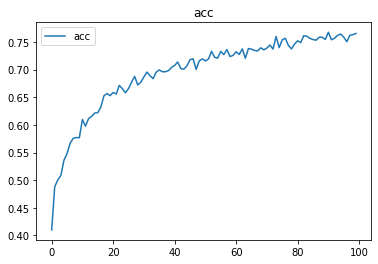

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

# Plot loss 

Text(0.5, 1.0, 'loss')

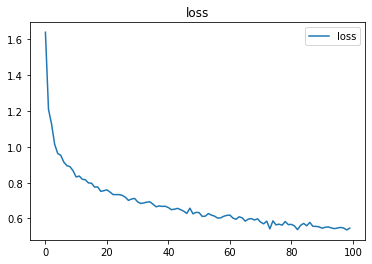

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')